# <center>A Comparative Study on Efficiencies of Variants of Convolutional Neural Networks based on Weather image recognition.</center>

# Importing common modules

Importing common modules for the entire file at the beginning.

In [127]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

# Connecting Dataset

Folder path of the entire image dataset.  
Storing the datapath of the images nested in the subfolders into a list.

In [128]:
dataset_path = '../Dataset'
dataset_images = list(glob.glob(dataset_path+'/**/*.jpg'))

# Converting the data to a Dataframe

Storing all the labels of each data into a list which is also the subfolder name of the particular image.  
Storing all the path of images starting from the dataset_path and the labels into a pandas series and then combining both the series to make it a dataframe.  
As we don't need the index/heading we are dropping them as well.

In [129]:
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], dataset_images))
file_path = pd.Series(dataset_images, name='File_Path').astype(str)
labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)

# Printing the first 10 data from the dataframe
data.head(10)

,File_Path,Labels
0,../Dataset\frost\3820.jpg,frost
1,../Dataset\rainbow\0698.jpg,rainbow
2,../Dataset\rainbow\0611.jpg,rainbow
3,../Dataset\glaze\6405.jpg,glaze
4,../Dataset\rime\6034.jpg,rime
5,../Dataset\lightning\2186.jpg,lightning
6,../Dataset\glaze\6567.jpg,glaze
7,../Dataset\snow\0952.jpg,snow
8,../Dataset\sandstorm\3556.jpg,sandstorm
9,../Dataset\snow\1307.jpg,snow


# Plotting few images with its labels

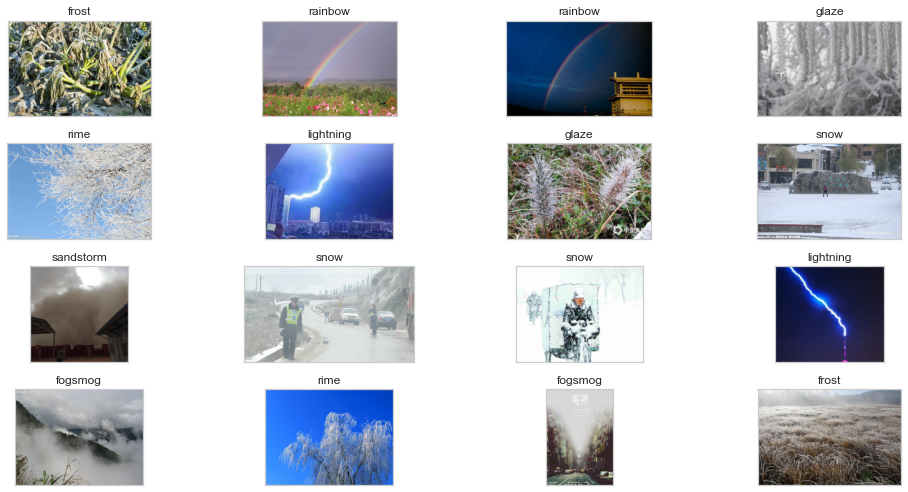

In [130]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Labels[i])
plt.tight_layout()
plt.show()

# Plot data count with labels

Plotting a bar chart representing the classes/labels with its data(image) count.  
This step comes in the EDA part as this will help us to understand the weight of data in each classes

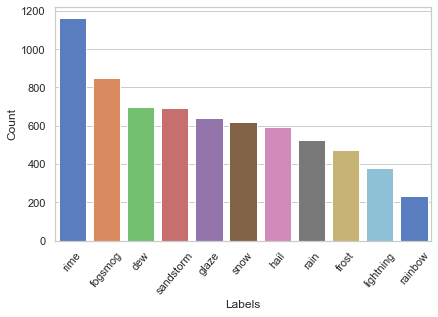

In [131]:
counts = data.Labels.value_counts()
sns.barplot(x=counts.index, y=counts, palette="muted")
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=50);

# Dataset Split

Shuffling the dataset and splitting it with 80% for the training and 20% for the testing. 

In [132]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=2)

# Function for Generating Data

We are generating different batches of image data in tensors with data augmentation.  
Data augmentation includes rotating, flipping, shearing, zooming, and shifting images.  
Then it is converted to the tensor data for further data processing.

In [133]:
def dataGenerator(pre,train,test):
    train_datagen = ImageDataGenerator(preprocessing_function=pre, validation_split=0.2)
    test_datagen = ImageDataGenerator(preprocessing_function=pre)
    
    # Read the images from the dataframe for the training set
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    
    # Read the images from the dataframe for the validation set
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=32,
        shuffle=False,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    
    # Read the images from the dataframe for the testing set
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        verbose=0,
        shuffle=False)
    return train_gen, valid_gen, test_gen

# Setup the named model with basic hyperparameters

We pass the model as argument and use that model to train the dataset with basic hyperparameters.

In [134]:
def modelFunc(name_model):
    pre_model = name_model(input_shape=(100,100, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input
    x = Dense(100, activation='relu')(pre_model.output)
    x = Dense(100, activation='relu')(x)
    outputs = Dense(11, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              mode='auto')]
    return model, my_callbacks

# Function for Plotting the training and validation result / data

In [135]:
def tr_plot(tr_data, start_epoch):
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()

# Function for plotting the data

**This function includes the prediction stage as well**.

Here we predict the data from generated testing dataset and generate a classification report as this is a multi-class classification algorithm.  
Generate and print out the confusion matrix.  
Display the comparison of real and predicted label with images.

In [136]:
def plot(history,test_gen,train_gen,model):
    
    pred = model.predict(test_gen )
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    
    cm=confusion_matrix(test_df.Labels,pred)
    clr = classification_report(test_df.Labels, pred)
    print(clr)
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(test_df.File_Path.iloc[i+1]))
        ax.set_title(f"True: {test_df.Labels.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()
    
    print('\n----------------------------')
    print('Training & Validation Result')
    print('----------------------------')
    
    tr_plot(history, 0)
        
    return history

# Function to print the Loss & Test accuracy from the results

In [137]:
def result_test(test,model_use):
    results = model_use.evaluate(test, verbose=0)
    
    print("    Test Loss: {:.5f}".format(results[0]))
    print("Test Accuracy: {:.2f}%".format(results[1] * 100))
    
    return results

---

# CNN Architectures

We are using different CNN (Convolutional Neural Network) architectures like **ResNet50, MobileNet, VGG19, VGG16, and DenseNet201**.

We mostly compare the performance of these architectures on this weather image dataset.

Also attached model summary of every model after the result. Where we have the structure of the particular model.

## ResNet50

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
43/43 [==============================] - 31s 689ms/step
              precision    recall  f1-score   support

         dew       0.94      0.87      0.90       120
     fogsmog       0.90      0.94      0.92       184
       frost       0.69      0.64      0.66       103
       glaze       0.74      0.64      0.69       115
        hail       0.96      0.86      0.90       104
   lightning       0.95      0.96      0.95        76
        rain       0.85      0.77      0.81       113
     rainbow       0.94      0.98      0.96        51
        rime       0.75      0.93      0.83       229
   sandstorm       0.95      0.89      0.92       143
        snow       0.68      0.67      0.67       135

    accuracy                           0.83      1373
   macro avg       0.85      0.83      0.84      1373


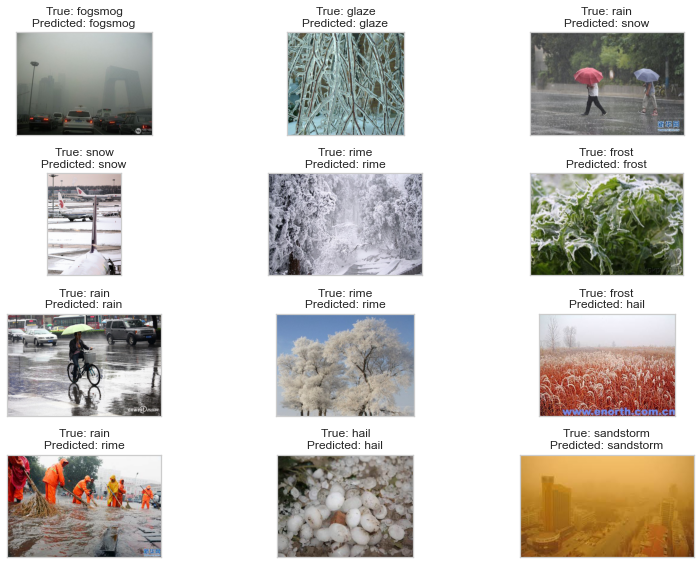


----------------------------
Training & Validation Result
----------------------------


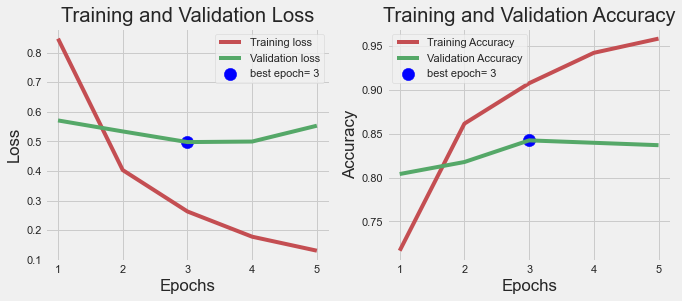

    Test Loss: 0.61586
Test Accuracy: 83.39%


In [138]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
ResNet_pre=preprocess_input
train_ResNet, valid_ResNet, test_ResNet = dataGenerator(ResNet_pre,train_df,test_df)
ResNet_model, callback=modelFunc(ResNet50)
history = ResNet_model.fit(
    train_ResNet,
    validation_data=valid_ResNet,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history_ResNet= plot(history,test_ResNet,train_ResNet, ResNet_model)

result_ResNet = result_test(test_ResNet,ResNet_model)

### Model Summary

In [139]:
ResNet_model.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_24[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1_conv[0][0]']      

 conv2_block3_2_conv (Conv2D)   (None, 25, 25, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 25, 25, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 25, 25, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 25, 25, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 13, 13, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 13, 13, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 13, 13, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 13, 13, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_2_conv (Conv2D)   (None, 7, 7, 256)    590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 7, 7, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 7, 7, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 7, 7, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block5_2_relu (Activatio  (None, 7, 7, 256)   0           ['conv4_block5_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 7, 7, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 7, 7, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 7, 7, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
          

 conv5_block2_2_relu (Activatio  (None, 4, 4, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 4, 4, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 4, 4, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 4, 4, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
          

## MobileNet

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
43/43 [==============================] - 13s 290ms/step
              precision    recall  f1-score   support

         dew       0.80      0.92      0.86       120
     fogsmog       0.88      0.88      0.88       184
       frost       0.81      0.54      0.65       103
       glaze       0.61      0.77      0.68       115
        hail       0.78      0.93      0.85       104
   lightning       0.93      0.97      0.95        76
        rain       0.90      0.81      0.86       113
     rainbow       0.96      0.92      0.94        51
        rime       0.83      0.83      0.83       229
   sandstorm       0.87      0.87      0.87       143
        snow       0.74      0.61      0.67       135

    accuracy                           0.82      1373
   macro avg       0.83      0.82      0.82      1373


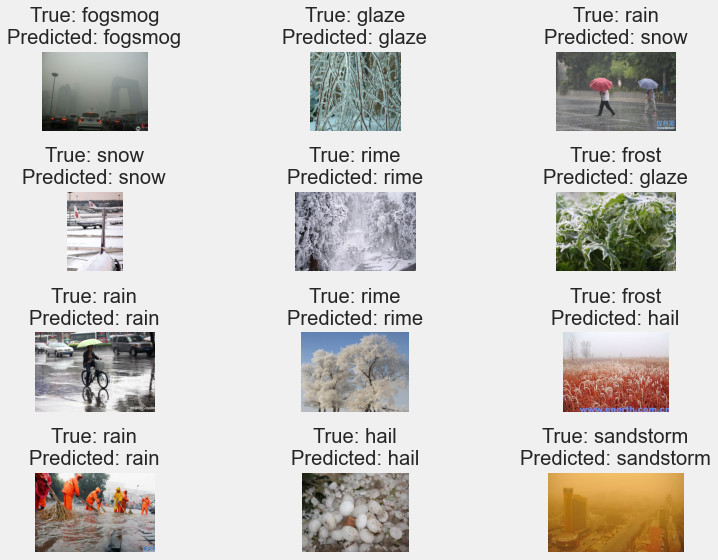


----------------------------
Training & Validation Result
----------------------------


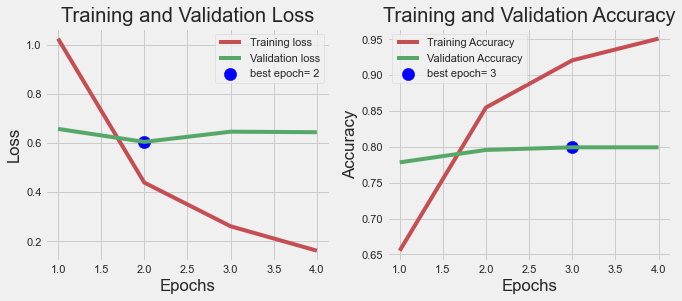

    Test Loss: 0.60736
Test Accuracy: 81.72%


In [140]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
MobileNet_pre=preprocess_input
train_gen_MobileNet, valid_gen_MobileNet, test_gen_MobileNet = dataGenerator(MobileNet_pre,train_df,test_df)
MobileNet_model, callback=modelFunc(MobileNet)
history = MobileNet_model.fit(
    train_gen_MobileNet,
    validation_data=valid_gen_MobileNet,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history_MobileNet = plot(history,test_gen_MobileNet,train_gen_MobileNet, MobileNet_model)

result_MobileNet = result_test(test_gen_MobileNet,MobileNet_model)

### Model Summary

In [141]:
MobileNet_model.summary()

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 50, 50, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 50, 50, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 50, 50, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 50, 50, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 50, 50, 32)       128       
 ation)                                                   

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 6, 6, 512)        2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 6, 6, 512)         0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 6, 6, 512)        4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 6, 6, 512)        2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 6, 6, 512)         0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 6, 6, 512)         262144    
                                                                 
 conv_pw_9

## VGG19

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
43/43 [==============================] - 73s 2s/step
              precision    recall  f1-score   support

         dew       0.93      0.82      0.87       120
     fogsmog       0.80      0.90      0.85       184
       frost       0.62      0.50      0.55       103
       glaze       0.52      0.73      0.61       115
        hail       0.86      0.86      0.86       104
   lightning       0.88      0.91      0.90        76
        rain       0.75      0.85      0.80       113
     rainbow       0.86      0.82      0.84        51
        rime       0.76      0.82      0.79       229
   sandstorm       0.97      0.81      0.89       143
        snow       0.71      0.50      0.59       135

    accuracy                           0.78      1373
   macro avg       0.79      0.77      0.78      1373
wei

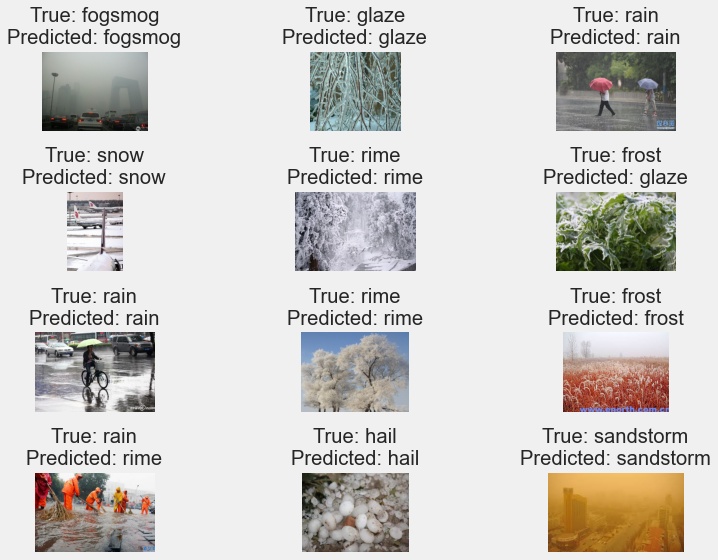


----------------------------
Training & Validation Result
----------------------------


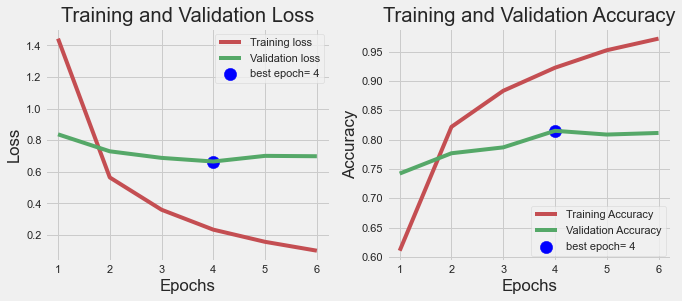

    Test Loss: 0.94412
Test Accuracy: 77.64%


In [142]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
VGG19_pre=preprocess_input
train_gen_VGG19, valid_gen_VGG19, test_gen_VGG19 = dataGenerator(VGG19_pre,train_df,test_df)
VGG19_model, callback=modelFunc(VGG19)
history = VGG19_model.fit(
    train_gen_VGG19,
    validation_data=valid_gen_VGG19,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history_VGG19= plot(history,test_gen_VGG19,train_gen_VGG19, VGG19_model)

result_VGG19 = result_test(test_gen_VGG19,VGG19_model)

### Model Summary

In [143]:
VGG19_model.summary()

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0  

## VGG16

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
43/43 [==============================] - 59s 1s/step
              precision    recall  f1-score   support

         dew       0.86      0.83      0.85       120
     fogsmog       0.87      0.92      0.89       184
       frost       0.75      0.43      0.54       103
       glaze       0.55      0.66      0.60       115
        hail       0.79      0.90      0.84       104
   lightning       0.91      0.95      0.93        76
        rain       0.86      0.75      0.80       113
     rainbow       0.94      0.86      0.90        51
        rime       0.75      0.88      0.81       229
   sandstorm       0.95      0.85      0.90       143
        snow       0.72      0.65      0.68       135

    accuracy                           0.80      1373
   macro avg       0.81      0.79      0.80      1373
wei

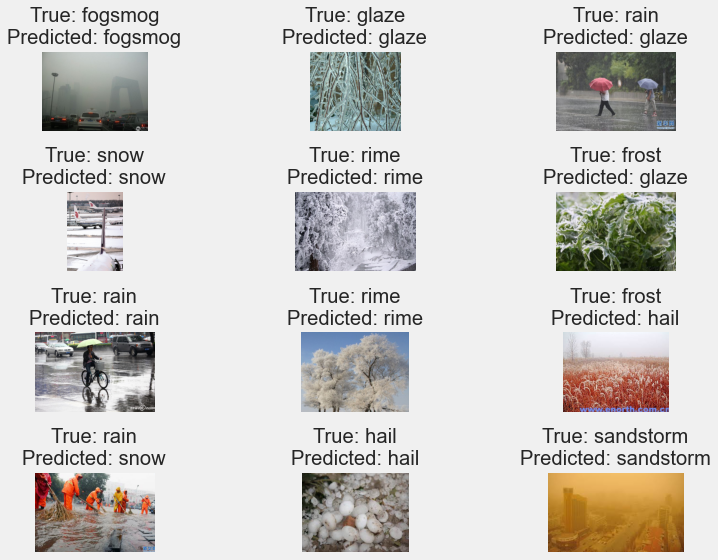


----------------------------
Training & Validation Result
----------------------------


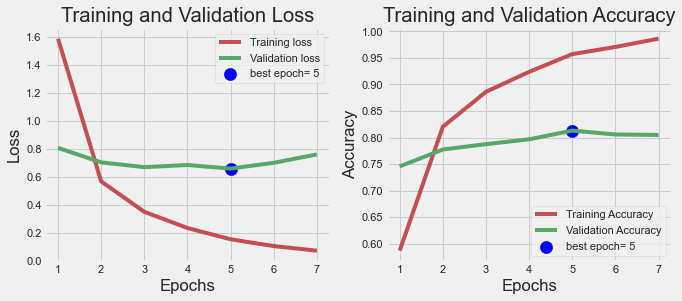

    Test Loss: 0.88372
Test Accuracy: 79.83%


In [144]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

vgg_pre=preprocess_input
train_gen_VGG, valid_gen_VGG, test_gen_VGG = dataGenerator(vgg_pre,train_df,test_df)
model_VGG16, callback=modelFunc(VGG16)
history = model_VGG16.fit(
    train_gen_VGG,
    validation_data=valid_gen_VGG,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history=plot(history,test_gen_VGG,train_gen_VGG, model_VGG16)
result_VGG16 = result_test(test_gen_VGG,model_VGG16)

### Model Summary

In [145]:
model_VGG16.summary()

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0  

## DenseNet201

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
43/43 [==============================] - 52s 1s/step
              precision    recall  f1-score   support

         dew       0.93      0.93      0.93       120
     fogsmog       0.89      0.91      0.90       184
       frost       0.72      0.73      0.72       103
       glaze       0.68      0.70      0.69       115
        hail       0.87      0.94      0.90       104
   lightning       0.99      0.96      0.97        76
        rain       0.70      0.92      0.80       113
     rainbow       1.00      0.96      0.98        51
        rime       0.86      0.86      0.86       229
   sandstorm       0.93      0.90      0.92       143
        snow       0.79      0.52      0.62       135

    accuracy                           0.84      1373
   macro avg       0.85      0.85      0.85      1373
wei

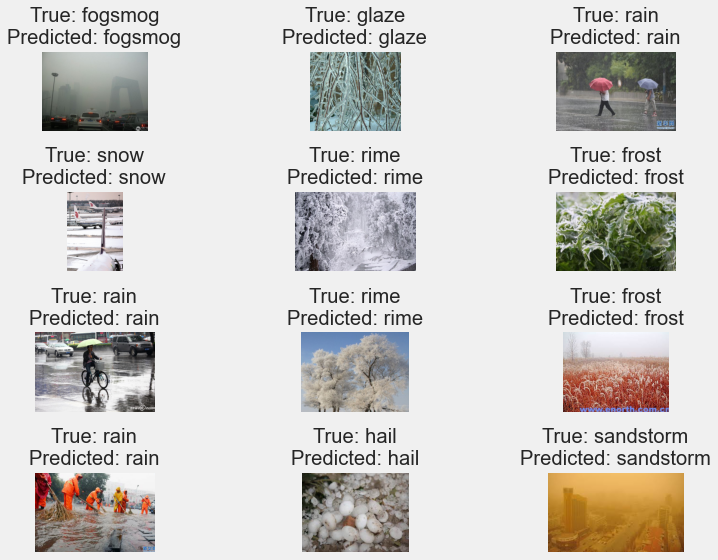


----------------------------
Training & Validation Result
----------------------------


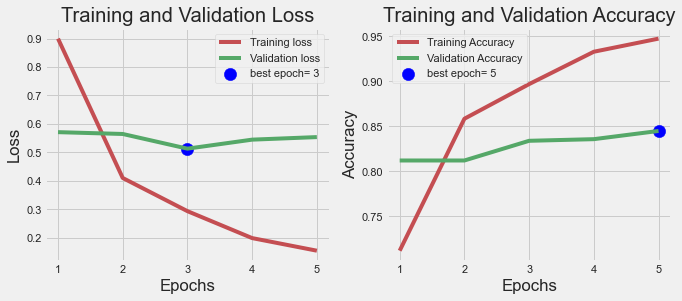

    Test Loss: 0.58170
Test Accuracy: 84.12%


In [146]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input

DenseNet201_pre=preprocess_input
train_gen_DenseNet201, valid_gen_DenseNet201, test_gen_DenseNet201 = dataGenerator(DenseNet201_pre,train_df,test_df)
model_DenseNet201, callback=modelFunc(DenseNet201)
history = model_DenseNet201.fit(
    train_gen_DenseNet201,
    validation_data=valid_gen_DenseNet201,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history=plot(history,test_gen_DenseNet201,train_gen_DenseNet201, model_DenseNet201)
result_DenseNet201 = result_test(test_gen_DenseNet201,model_DenseNet201)

### Model Summary

In [147]:
model_DenseNet201.summary()

Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_8 (ZeroPadding2  (None, 106, 106, 3)  0          ['input_28[0][0]']               
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 50, 50, 64)   9408        ['zero_padding2d_8[0][0]']       
                                                                                           

 conv2_block4_1_conv (Conv2D)   (None, 25, 25, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 25, 25, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 25, 25, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_2_conv (Conv2D)   (None, 25, 25, 32)   36864       ['conv2_block4_1_relu[0][0]']    
                                                                                                  
 conv2_blo

                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 12, 12, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 12, 12, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 12, 12, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 12, 12, 32)   36864       ['conv3_block2_1_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 12, 12, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 12, 12, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 12, 12, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_blo

 conv3_block11_0_bn (BatchNorma  (None, 12, 12, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 12, 12, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 12, 12, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_block11_1_bn (BatchNorma  (None, 12, 12, 128)  512        ['conv3_block11_1_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 6, 6, 320)   1280        ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 6, 6, 320)   0           ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 6, 6, 128)    40960       ['conv4_block3_0_relu[0][0]']    
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 6, 6, 128)   512         ['conv4_block3_1_conv[0][0]']    
 ization) 

 conv4_block7_1_conv (Conv2D)   (None, 6, 6, 128)    57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 6, 6, 128)   512         ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 6, 6, 128)   0           ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 6, 6, 32)     36864       ['conv4_block7_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 6, 6, 32)     36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 6, 6, 608)   0           ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 6, 6, 608)   2432        ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block12_0_relu (Activati  (None, 6, 6, 608)   0           ['conv4_block12_0_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 6, 6, 736)   0           ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 6, 6, 128)    94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 6, 6, 128)   512         ['conv4_block16_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block20_1_bn (BatchNorma  (None, 6, 6, 128)   512         ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 6, 6, 128)   0           ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 6, 6, 32)     36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_block20_concat (Concaten  (None, 6, 6, 896)   0           ['conv4_block19_concat[0][0]',   
 ate)                                                             'conv4_block20_2_conv[0][0]']   
          

                                                                                                  
 conv4_block24_concat (Concaten  (None, 6, 6, 1024)  0           ['conv4_block23_concat[0][0]',   
 ate)                                                             'conv4_block24_2_conv[0][0]']   
                                                                                                  
 conv4_block25_0_bn (BatchNorma  (None, 6, 6, 1024)  4096        ['conv4_block24_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block25_0_relu (Activati  (None, 6, 6, 1024)  0           ['conv4_block25_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block29_0_relu (Activati  (None, 6, 6, 1152)  0           ['conv4_block29_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block29_1_conv (Conv2D)  (None, 6, 6, 128)    147456      ['conv4_block29_0_relu[0][0]']   
                                                                                                  
 conv4_block29_1_bn (BatchNorma  (None, 6, 6, 128)   512         ['conv4_block29_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block29_1_relu (Activati  (None, 6, 6, 128)   0           ['conv4_block29_1_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block33_1_relu (Activati  (None, 6, 6, 128)   0           ['conv4_block33_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block33_2_conv (Conv2D)  (None, 6, 6, 32)     36864       ['conv4_block33_1_relu[0][0]']   
                                                                                                  
 conv4_block33_concat (Concaten  (None, 6, 6, 1312)  0           ['conv4_block32_concat[0][0]',   
 ate)                                                             'conv4_block33_2_conv[0][0]']   
                                                                                                  
 conv4_block34_0_bn (BatchNorma  (None, 6, 6, 1312)  5248        ['conv4_block33_concat[0][0]']   
 lization)

 ate)                                                             'conv4_block37_2_conv[0][0]']   
                                                                                                  
 conv4_block38_0_bn (BatchNorma  (None, 6, 6, 1440)  5760        ['conv4_block37_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block38_0_relu (Activati  (None, 6, 6, 1440)  0           ['conv4_block38_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block38_1_conv (Conv2D)  (None, 6, 6, 128)    184320      ['conv4_block38_0_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block42_1_conv (Conv2D)  (None, 6, 6, 128)    200704      ['conv4_block42_0_relu[0][0]']   
                                                                                                  
 conv4_block42_1_bn (BatchNorma  (None, 6, 6, 128)   512         ['conv4_block42_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block42_1_relu (Activati  (None, 6, 6, 128)   0           ['conv4_block42_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block42_2_conv (Conv2D)  (None, 6, 6, 32)     36864       ['conv4_block42_1_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv4_block46_2_conv (Conv2D)  (None, 6, 6, 32)     36864       ['conv4_block46_1_relu[0][0]']   
                                                                                                  
 conv4_block46_concat (Concaten  (None, 6, 6, 1728)  0           ['conv4_block45_concat[0][0]',   
 ate)                                                             'conv4_block46_2_conv[0][0]']   
                                                                                                  
 conv4_block47_0_bn (BatchNorma  (None, 6, 6, 1728)  6912        ['conv4_block46_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv5_block2_1_relu (Activatio  (None, 3, 3, 128)   0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 3, 3, 32)     36864       ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_block2_concat (Concatena  (None, 3, 3, 960)   0           ['conv5_block1_concat[0][0]',    
 te)                                                              'conv5_block2_2_conv[0][0]']    
                                                                                                  
 conv5_block3_0_bn (BatchNormal  (None, 3, 3, 960)   3840        ['conv5_block2_concat[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv5_block7_0_bn (BatchNormal  (None, 3, 3, 1088)  4352        ['conv5_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block7_0_relu (Activatio  (None, 3, 3, 1088)  0           ['conv5_block7_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block7_1_conv (Conv2D)   (None, 3, 3, 128)    139264      ['conv5_block7_0_relu[0][0]']    
                                                                                                  
 conv5_block7_1_bn (BatchNormal  (None, 3, 3, 128)   512         ['conv5_block7_1_conv[0][0]']    
 ization) 

 conv5_block11_1_conv (Conv2D)  (None, 3, 3, 128)    155648      ['conv5_block11_0_relu[0][0]']   
                                                                                                  
 conv5_block11_1_bn (BatchNorma  (None, 3, 3, 128)   512         ['conv5_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block11_1_relu (Activati  (None, 3, 3, 128)   0           ['conv5_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block11_2_conv (Conv2D)  (None, 3, 3, 32)     36864       ['conv5_block11_1_relu[0][0]']   
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block15_2_conv (Conv2D)  (None, 3, 3, 32)     36864       ['conv5_block15_1_relu[0][0]']   
                                                                                                  
 conv5_block15_concat (Concaten  (None, 3, 3, 1376)  0           ['conv5_block14_concat[0][0]',   
 ate)                                                             'conv5_block15_2_conv[0][0]']   
                                                                                                  
 conv5_block16_0_bn (BatchNorma  (None, 3, 3, 1376)  5504        ['conv5_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block16_0_relu (Activati  (None, 3, 3, 1376)  0           ['conv5_block16_0_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv5_block20_0_relu (Activati  (None, 3, 3, 1504)  0           ['conv5_block20_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block20_1_conv (Conv2D)  (None, 3, 3, 128)    192512      ['conv5_block20_0_relu[0][0]']   
                                                                                                  
 conv5_block20_1_bn (BatchNorma  (None, 3, 3, 128)   512         ['conv5_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_blo

 conv5_block24_1_bn (BatchNorma  (None, 3, 3, 128)   512         ['conv5_block24_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block24_1_relu (Activati  (None, 3, 3, 128)   0           ['conv5_block24_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block24_2_conv (Conv2D)  (None, 3, 3, 32)     36864       ['conv5_block24_1_relu[0][0]']   
                                                                                                  
 conv5_block24_concat (Concaten  (None, 3, 3, 1664)  0           ['conv5_block23_concat[0][0]',   
 ate)                                                             'conv5_block24_2_conv[0][0]']   
          

                                                                                                  
 conv5_block28_concat (Concaten  (None, 3, 3, 1792)  0           ['conv5_block27_concat[0][0]',   
 ate)                                                             'conv5_block28_2_conv[0][0]']   
                                                                                                  
 conv5_block29_0_bn (BatchNorma  (None, 3, 3, 1792)  7168        ['conv5_block28_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block29_0_relu (Activati  (None, 3, 3, 1792)  0           ['conv5_block29_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_blo

                                                                                                  
 avg_pool (GlobalAveragePooling  (None, 1920)        0           ['relu[0][0]']                   
 2D)                                                                                              
                                                                                                  
 dense_81 (Dense)               (None, 100)          192100      ['avg_pool[0][0]']               
                                                                                                  
 dense_82 (Dense)               (None, 100)          10100       ['dense_81[0][0]']               
                                                                                                  
 dense_83 (Dense)               (None, 11)           1111        ['dense_82[0][0]']               
                                                                                                  
Total para

---

# Adding results(Accuracy) of the model to a dataframe

In [148]:
output = pd.DataFrame({'Model':['ResNet50','MobileNet','VGG19', 'VGG16','DenseNet201'],
                      'Accuracy': [result_ResNet[1], result_MobileNet[1], result_VGG19[1], 
                                   result_VGG16[1], result_DenseNet201[1]]})

# Plotting the Accuracy of different models

This is the plotting of final accuracy got by the models in this dataset and compared across a bar plot.

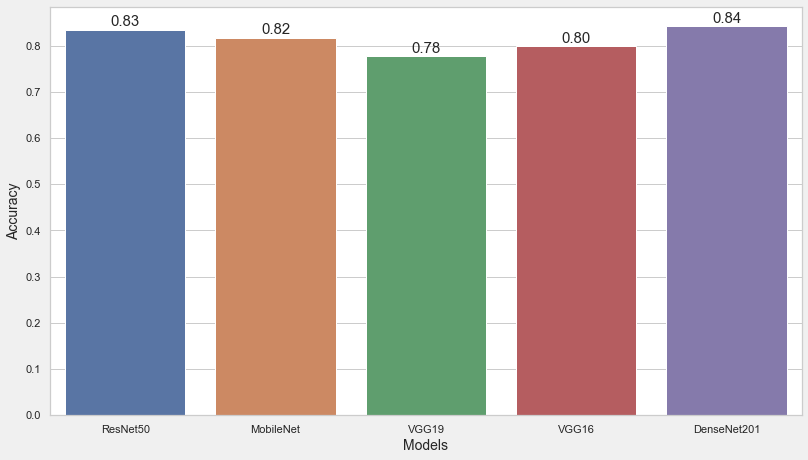

In [149]:
plt.figure(figsize=(12, 7))
sns.set_theme(style="whitegrid")
plots = sns.barplot(x='Model', y='Accuracy', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models", size=14)
plt.ylabel("Accuracy", size=14)
plt.show()